In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import numpy as np

tf.logging.set_verbosity(tf.logging.INFO)

In [2]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    #MNIST dataset is composed of monochrome 28x28 pixel images, so the desired shape for our input layer is [batch_size, 28, 28, 1]
    input_layer = tf.reshape(features['image'], [-1, 28, 28, 1])
    #The methods in the layers module for creating convolutional and pooling layers 
     
    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
          inputs=input_layer,
          filters=32,
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
          inputs=pool1,
          filters=64,
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    #flatten our feature map (pool2) to shape [batch_size, features], so that our tensor has only two dimensions:
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    #Each example has 7 (pool2 height) * 7 (pool2 width) * 64 (pool2 channels) features,
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
          inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

      # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
          # Generate predictions (for PREDICT and EVAL mode)
          "classes": tf.argmax(input=logits, axis=1),
          # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
          # `logging_hook`.
          "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
      }

    if mode == tf.estimator.ModeKeys.PREDICT:
        export_outputs = {
              'prediction': tf.estimator.export.PredictOutput(predictions)
          }
        return tf.estimator.EstimatorSpec(
              mode, predictions=predictions, export_outputs=export_outputs)
        

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

      # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
          "accuracy": tf.metrics.accuracy(
              labels=labels, predictions=predictions["classes"])
      }
    return tf.estimator.EstimatorSpec(
          mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [3]:
# Load training and eval data
((train_data, train_labels),
 (eval_data, eval_labels)) = tf.keras.datasets.mnist.load_data()

train_data = train_data/np.float32(255)
train_labels = train_labels.astype(np.int32)  # not required

eval_data = eval_data/np.float32(255)
eval_labels = eval_labels.astype(np.int32)  # not required

In [6]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}

logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

In [4]:
HEIGHT = 28
WIDTH = 28
NUM_CHANNELS = 1
def serving_input_fn():
    # Note: only handles one image at a time 
    feature_placeholders = {"image_bytes": tf.placeholder(dtype = tf.string, shape = [])}
    image, _ = read_and_preprocess(
        tf.squeeze(input = feature_placeholders["image_bytes"]))
    image["image"] = tf.expand_dims(input = image["image"], axis = 0)
    return tf.estimator.export.ServingInputReceiver(features = image, receiver_tensors = feature_placeholders)
  
def read_and_preprocess(image_bytes, label = None, augment = False):
    # Decode the image, end up with pixel values that are in the -1, 1 range
    image = tf.image.decode_jpeg(contents = image_bytes, channels = NUM_CHANNELS)
    image = tf.image.convert_image_dtype(image = image, dtype = tf.float32) # 0-1
    image = tf.expand_dims(input = image, axis = 0) # resize_bilinear needs batches
    
    if augment:
        image = tf.image.resize_bilinear(images = image, size = [HEIGHT + 10, WIDTH + 10], align_corners = False)
        image = tf.squeeze(input = image, axis = 0) # remove batch dimension
        image = tf.random_crop(value = image, size = [HEIGHT, WIDTH, NUM_CHANNELS])
        image = tf.image.random_flip_left_right(image = image)
        image = tf.image.random_brightness(image = image, max_delta = 63.0 / 255.0)
        image = tf.image.random_contrast(image = image, lower = 0.2, upper = 1.8)
    else:
        image = tf.image.resize_bilinear(images = image, size = [HEIGHT, WIDTH], align_corners = False)
        image = tf.squeeze(input = image, axis = 0) # remove batch dimension
        
    # Pixel values are in range [0,1], convert to [-1,1]
    image = tf.subtract(x = image, y = 0.5)
    image = tf.multiply(x = image, y = 2.0)
    return {"image": image}, label

In [14]:
mnist_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="mnist_convnet_model")
def train_and_evaluate(output_dir, num_train_steps):
    
    train_input_fn = tf.estimator.inputs.numpy_input_fn(x={"image": train_data},y=train_labels,batch_size=100,num_epochs=None,shuffle=True)
  
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(x={"image": eval_data},y=eval_labels,num_epochs=1,shuffle=False)

    train_spec=tf.estimator.TrainSpec(input_fn = train_input_fn, max_steps = num_train_steps)
    #read_dataset('./train.csv',mode = tf.estimator.ModeKeys.TRAIN)
    exporter = tf.estimator.LatestExporter('exporter', serving_input_fn)
    eval_spec=tf.estimator.EvalSpec(
                       input_fn = eval_input_fn,
                       steps = None,
                       start_delay_secs = 1, # start evaluating after N seconds
                       throttle_secs = 10,  # evaluate every N seconds
                       exporters = exporter)
    tf.estimator.train_and_evaluate(mnist_classifier, train_spec, eval_spec)

I0707 08:04:21.899794 140624835032832 estimator.py:1790] Using default config.
I0707 08:04:21.902186 140624835032832 estimator.py:209] Using config: {'_log_step_count_steps': 100, '_experimental_distribute': None, '_num_worker_replicas': 1, '_evaluation_master': '', '_protocol': None, '_eval_distribute': None, '_is_chief': True, '_keep_checkpoint_max': 5, '_device_fn': None, '_global_id_in_cluster': 0, '_master': '', '_task_type': 'worker', '_model_dir': 'mnist_convnet_model', '_save_summary_steps': 100, '_tf_random_seed': None, '_save_checkpoints_steps': None, '_train_distribute': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe504c19a58>, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_num_ps_replicas': 0, '_service': None, '_experimental_max_worker_delay_secs': None, '_save_checkpoints_secs': 600}


In [15]:
# Run training  
import shutil
OUTDIR = 'mnist_convnet_model'
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time
train_and_evaluate(OUTDIR, num_train_steps = 2000)

I0707 08:04:40.234121 140624835032832 estimator_training.py:186] Not using Distribute Coordinator.
I0707 08:04:40.235668 140624835032832 training.py:612] Running training and evaluation locally (non-distributed).
I0707 08:04:40.236810 140624835032832 training.py:700] Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
I0707 08:04:40.271170 140624835032832 estimator.py:1145] Calling model_fn.
I0707 08:04:40.484861 140624835032832 estimator.py:1147] Done calling model_fn.
I0707 08:04:40.489242 140624835032832 basic_session_run_hooks.py:541] Create CheckpointSaverHook.
I0707 08:04:40.576490 140624835032832 monitored_session.py:240] Graph was finalized.
I0707 08:04:40.683209 140624835032832 session_manager.py:500] Running local_init_op.
I0707 08:04:40.689953 140624835032832 session_manager.py:502] Done running local_init_op.
I0707 08:04:40.9

In [7]:
import os
PROJECT = 'cpb100-245606' # REPLACE WITH YOUR PROJECT ID
REGION = 'us-east1' 
BUCKET = 'my_demo_model' # REPLACE WITH YOUR bucket name
  


In [8]:

# for bash
os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION
os.environ['TFVERSION'] = '1.4' 

In [9]:

%%bash
PROJECT_ID=$PROJECT
AUTH_TOKEN=$(gcloud auth print-access-token)
SVC_ACCOUNT=$(curl -X GET -H "Content-Type: application/json" \
    -H "Authorization: Bearer $AUTH_TOKEN" \
    https://ml.googleapis.com/v1/projects/${PROJECT_ID}:getConfig \
    | python -c "import json; import sys; response = json.load(sys.stdin); \
    print(response['serviceAccount'])")

echo "Authorizing the Cloud ML Service account $SVC_ACCOUNT to access files in $BUCKET"
#gsutil -m defacl ch -u $SVC_ACCOUNT:R gs://$BUCKET
#gsutil -m acl ch -u $SVC_ACCOUNT:R -r gs://$BUCKET  # error message (if bucket is empty) can be ignored
#gsutil -m acl ch -u $SVC_ACCOUNT:W gs://$BUCKET

Authorizing the Cloud ML Service account service-578381499295@cloud-ml.google.com.iam.gserviceaccount.com to access files in my_demo_model


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   233    0   233    0     0    665      0 --:--:-- --:--:-- --:--:--   665


In [16]:
%%bash
echo $BUCKET
#Upload saved model to bucket, replace 1562483410 with your subfolder containing the latest saved model
gsutil -m cp ${PWD}/mnist_convnet_model/export/exporter/1562487022/*.* gs://${BUCKET}/mnist_convnet_model/
gsutil -m cp ${PWD}/mnist_convnet_model/export/exporter/1562487022/variables/*.* gs://${BUCKET}/mnist_convnet_model/variables/

my_demo_model


Copying file:///home/jupyter/mnist_convnet_model/export/exporter/1562487022/saved_model.pb [Content-Type=application/octet-stream]...
/ [1/1 files][ 23.4 KiB/ 23.4 KiB] 100% Done                                    
Operation completed over 1 objects/23.4 KiB.                                     
Copying file:///home/jupyter/mnist_convnet_model/export/exporter/1562487022/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/mnist_convnet_model/export/exporter/1562487022/variables/variables.index [Content-Type=application/octet-stream]...
-
Operation completed over 2 objects/12.5 MiB.                                     


I0707 08:19:53.338560 140624835032832 estimator.py:1145] Calling model_fn.
I0707 08:19:53.426802 140624835032832 estimator.py:1147] Done calling model_fn.
I0707 08:19:53.512462 140624835032832 monitored_session.py:240] Graph was finalized.
I0707 08:19:53.515906 140624835032832 saver.py:1280] Restoring parameters from mnist_convnet_model/model.ckpt-2000


expected class:  6


I0707 08:19:53.581781 140624835032832 session_manager.py:500] Running local_init_op.
I0707 08:19:53.587033 140624835032832 session_manager.py:502] Done running local_init_op.


{'probabilities': array([0.03396588, 0.00908962, 0.17241697, 0.0268354 , 0.11940932,
       0.04745677, 0.47018716, 0.02021108, 0.05498011, 0.0454477 ],
      dtype=float32), 'classes': 6}


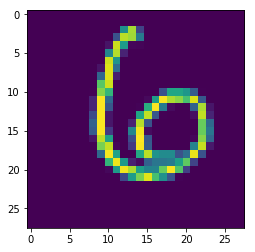

In [30]:
from matplotlib import pyplot as plt
plt.imshow(eval_data[100])
pred = mnist_classifier.predict(input_fn=tf.estimator.inputs.numpy_input_fn(
      x={"image": eval_data[100]},
      shuffle=False))

print('expected class: ',eval_labels[100])
for p in pred:
    print(p)